In [ ]:
%pip install torch
%pip install torchvision
%pip install torchsummary
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install pillow

In [49]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os

from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [51]:
device

'cpu'

In [52]:
image_paths = []
labels = []

for i in os.listdir('./afhq'):
    for label in os.listdir(f'./afhq/{i}'):
        for img in os.listdir(f'./afhq/{i}/{label}'):
            image_paths.append(f'./afhq/{i}/{label}/{img}')
            labels.append(label)

df = pd.DataFrame(zip(image_paths, labels), columns=['image_path', 'label'])

In [53]:
df.head()

,image_path,label
0,./afhq/train/cat/flickr_cat_000002.jpg,cat
1,./afhq/train/cat/flickr_cat_000003.jpg,cat
2,./afhq/train/cat/flickr_cat_000004.jpg,cat
3,./afhq/train/cat/flickr_cat_000005.jpg,cat
4,./afhq/train/cat/flickr_cat_000006.jpg,cat


In [54]:
df['label'].unique()

array(['cat', 'dog', 'wild'], dtype=object)

In [55]:
train = df.sample(frac=0.7)
test = df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

In [56]:
train.shape, val.shape, test.shape

((11291, 2), (2420, 2), (2419, 2))

In [57]:
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

In [58]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.Tensor(label_encoder.transform(dataframe['label'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image).to(device)
        return image, label

In [59]:
train_dataset = CustomImageDataset(train, transform)
val_dataset = CustomImageDataset(val, transform)
test_dataset = CustomImageDataset(test, transform)

In [60]:
label_encoder.inverse_transform([0, 1, 2])

array(['cat', 'dog', 'wild'], dtype=object)

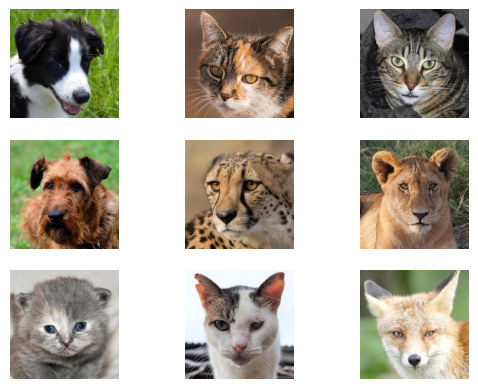

In [61]:
n_rows = 3
n_cols = 3

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        img = Image.open(df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
        axs[row, col].imshow(img)
        axs[row, col].axis('off')


In [62]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [63]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # (32, 128, 128)
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 64, 64)
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (64, 64, 64)
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 32, 32)
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # (128, 32, 32)
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 16, 16)
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(in_features=(128 * 16 * 16), out_features=128),
            nn.Linear(in_features=128, out_features=len(df['label'].unique())),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequential(x)

In [65]:
model = Net().to(device)

In [66]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

- 多分类问题使用交叉熵损失函数（nn.CrossEntropyLoss()）
- 二分类问题使用二分类损失函数（nn.BCELoss() 或者 nn.BCEWithLogitsLoss()）

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [68]:
total_loss_train_plot = []
total_loss_val_plot = []

total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_loss_train = 0
    total_acc_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(inputs)

        train_loss = loss_fn(outputs, labels)

        train_loss.backward()
        optimizer.step()

        total_loss_train += train_loss.item()
        total_acc_train += labels.eq(outputs.argmax(dim=1)).sum().item()

    with torch.inference_mode():
        for inputs, labels in val_loader:
            labels = labels.long()

            outputs = model(inputs)

            val_loss = loss_fn(outputs, labels)

            total_loss_val += val_loss.item()
            total_acc_val += labels.eq(outputs.argmax(dim=1)).sum().item()

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_val_plot.append(round(total_loss_val / 1000, 4))

    total_acc_train_plot.append(round(total_acc_train / train_dataset.__len__() * 100, 4))
    total_acc_val_plot.append(round(total_acc_val / val_dataset.__len__() * 100, 4))


    print(f'Epoch {epoch + 1}/{EPOCHS}, train_loss: {total_loss_train_plot[-1]}, train_acc: {total_acc_train_plot[-1]}, val_loss: {total_loss_val_plot[-1]}, val_acc: {total_acc_val_plot[-1]}')


Epoch 1/10, train_loss: 0.3209, train_acc: 81.1531, val_loss: 0.0337, val_acc: 91.9008
Epoch 2/10, train_loss: 0.1296, train_acc: 93.2424, val_loss: 0.0227, val_acc: 94.9587
Epoch 3/10, train_loss: 0.0836, train_acc: 95.616, val_loss: 0.0192, val_acc: 95.3306
Epoch 4/10, train_loss: 0.0601, train_acc: 96.9622, val_loss: 0.0183, val_acc: 95.6612
Epoch 5/10, train_loss: 0.0446, train_acc: 97.7504, val_loss: 0.0183, val_acc: 95.8678
Epoch 6/10, train_loss: 0.0327, train_acc: 98.2552, val_loss: 0.017, val_acc: 96.1157
Epoch 7/10, train_loss: 0.0224, train_acc: 98.9106, val_loss: 0.0187, val_acc: 95.5372
Epoch 8/10, train_loss: 0.02, train_acc: 99.0081, val_loss: 0.0192, val_acc: 95.7851
Epoch 9/10, train_loss: 0.0144, train_acc: 99.2118, val_loss: 0.0177, val_acc: 96.7769
Epoch 10/10, train_loss: 0.0089, train_acc: 99.6192, val_loss: 0.018, val_acc: 96.7769


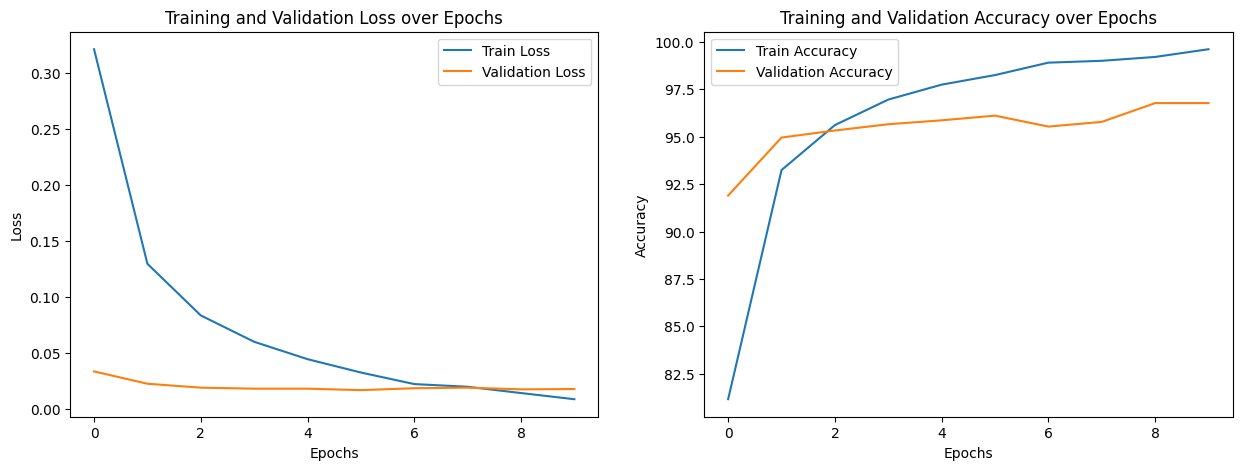

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Train Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()


axs[1].plot(total_acc_train_plot, label='Train Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


In [70]:
with torch.inference_mode():
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in test_loader:
        labels = labels.long()

        outputs = model(inputs)

        test_loss = loss_fn(outputs, labels)

        total_loss_test += test_loss.item()
        total_acc_test += labels.eq(outputs.argmax(dim=1)).sum().item()

    print(f'test_loss: {round(total_loss_test / 1000, 4)}, test_acc: {round(total_acc_test / test_dataset.__len__() * 100, 4)}')

test_loss: 0.0204, test_acc: 96.1968


#### Predict a image
- read image
- transform using transform object
- predict through model
- inverse transform by label encoder

In [71]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    output = model(image)
    output = output.argmax(dim=1)
    return label_encoder.inverse_transform(output)

In [72]:
predict_image('cat.jpg')

array(['cat'], dtype=object)